In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [51]:
dataset1 = pd.read_csv("data/S07-hw-dataset-01.csv")
print(dataset1.head())
print(dataset1.info())
dataset1.describe()
X1 = dataset1.iloc[:, 1:]
sample_id1 = dataset1["sample_id"]

   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04 

In [7]:
dataset2 = pd.read_csv("data/S07-hw-dataset-02.csv")
print(dataset2.head())
print(dataset2.info())
dataset2.describe()
X2 = dataset2.iloc[:, 1:]
sample_id2 = dataset2["sample_id"]

   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None


In [8]:
dataset3 = pd.read_csv("data/S07-hw-dataset-03.csv")
print(dataset3.head())
print(dataset3.info())
dataset3.describe()
X3 = dataset3.iloc[:, 1:]
sample_id3 = dataset3["sample_id"]

   sample_id        x1        x2    f_corr   f_noise
0          0 -2.710470  4.997107 -1.015703  0.718508
1          1  8.730238 -8.787416  3.953063 -1.105349
2          2 -1.079600 -2.558708  0.976628 -3.605776
3          3  6.854042  1.560181  1.760614 -1.230946
4          4  9.963812 -8.869921  2.966583  0.915899
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None


Во всех трех датасетах отсутствуют пропуски и категориальные признаки. Все признаки числовые.

In [9]:
# препроцессинг
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(X3)

Xes = [X1_scaled, X2_scaled, X3_scaled]

In [10]:
# сетки для подбора гиперпараметров
kmeans_ks = list(range(2, 21))

dbscan_eps = [0.1, 0.3, 0.5, 0.7, 0.9]
dbscan_min_samples = [3, 5, 10]

def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception as e:
        print(e)
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

dataset 1: {'k': 2} 0.522


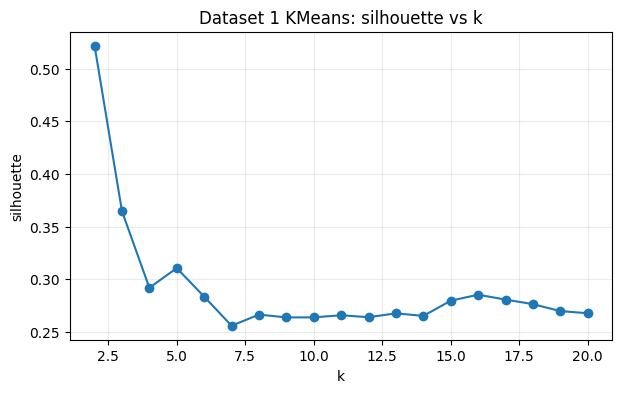

dataset 2: {'k': 2} 0.307


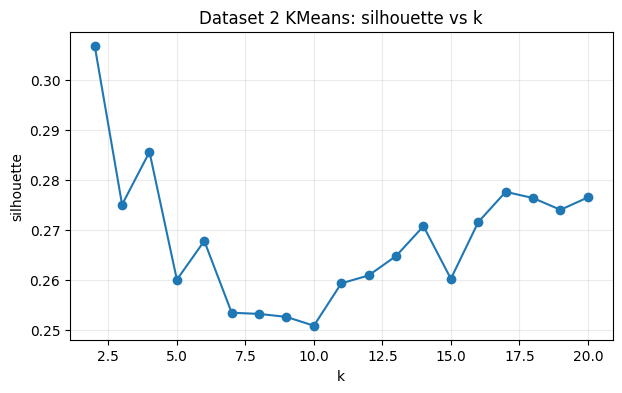

dataset 3: {'k': 3} 0.316


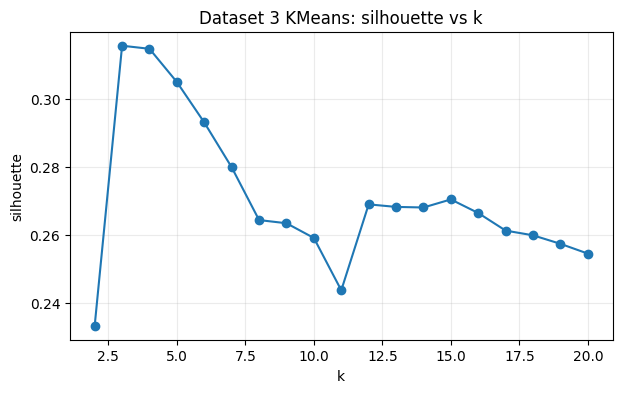

In [11]:
# K Means
def eval_kmeans_grid(X_feat, ks, random_state=RANDOM_STATE):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=random_state, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results


def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score


def plot_sil_vs_k(results, dataset_number: int):
    ks = [r["params"]["k"] for r in results]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in results]

    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title(f"Dataset {dataset_number} KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.savefig(f"artifacts/figures/silhouette_k_{dataset_number}.png")
    plt.show()

kmeans_results = []
best_kmeans_123 = []
for dataset_num, X in enumerate(Xes, 1):
    result = eval_kmeans_grid(X, kmeans_ks)
    best_kmeans, best_kmeans_sil = pick_best_by_silhouette(result)
    best_kmeans_123.append(best_kmeans)
    print(f"dataset {dataset_num}:", best_kmeans["params"], round(best_kmeans_sil, 3))
    plot_sil_vs_k(result, dataset_num)
    kmeans_results.append(result)

In [12]:
# DBSCAN
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            
            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results


dbscan_results = []
best_dbscan_123 = []
for dataset_num, X in enumerate(Xes, 1):
    result = eval_dbscan_grid(X, dbscan_eps, dbscan_min_samples)
    best_dbscan, best_dbscan_sil = pick_best_by_silhouette(result)
    best_dbscan_123.append(best_dbscan)
    print(f"dataset {dataset_num}:", best_dbscan["params"], best_dbscan["n_clusters"], round(best_dbscan_sil, 3))
    print(f"noise frac = {round(best_dbscan["noise_frac"], 3)}")
    dbscan_results.append(result)
    

dataset 1: {'eps': 0.7, 'min_samples': 10} 5 0.381
noise frac = 0.007
dataset 2: {'eps': 0.1, 'min_samples': 10} 46 0.581
noise frac = 0.918
dataset 3: {'eps': 0.1, 'min_samples': 10} 5 0.812
noise frac = 0.996


In [13]:
# выбираем лучший результат для каждого датасета по silhouette
best_1 = max(best_kmeans_123[0], best_dbscan_123[0], key=lambda res: res["metrics"]["silhouette"])
best_2 = max(best_kmeans_123[1], best_dbscan_123[1], key=lambda res: res["metrics"]["silhouette"])
best_3 = max(best_kmeans_123[2], best_dbscan_123[2], key=lambda res: res["metrics"]["silhouette"])

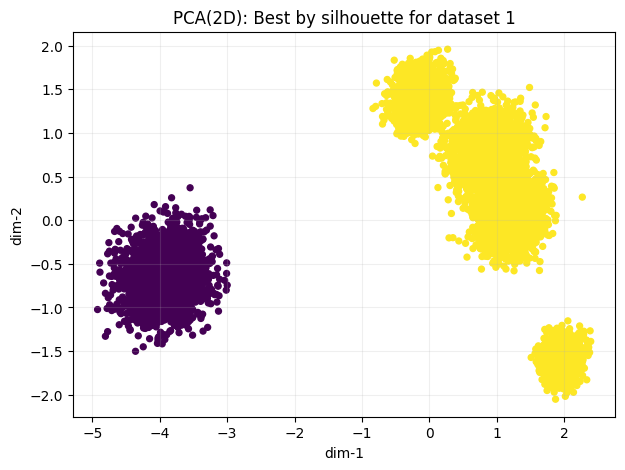

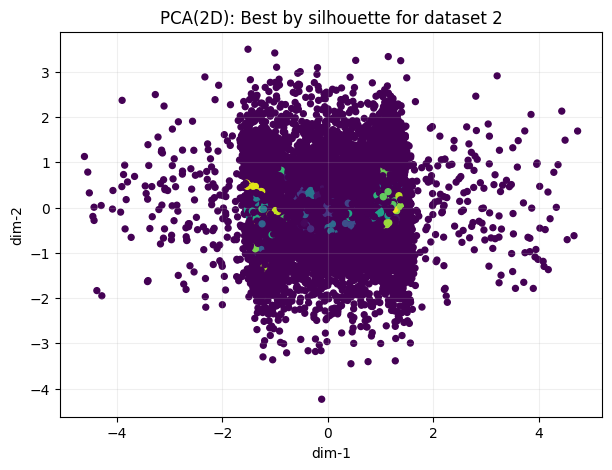

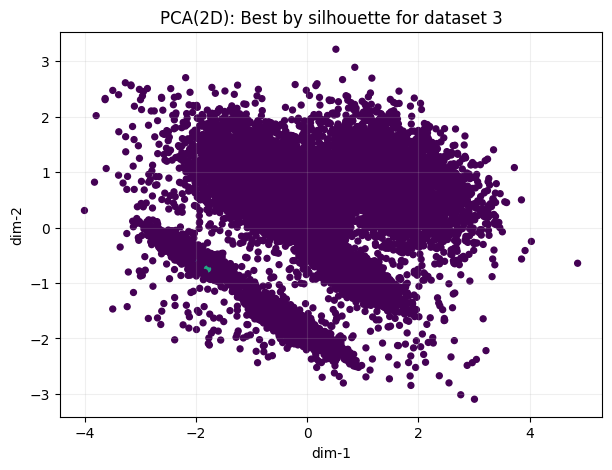

In [14]:
def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, dataset_num):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(f"PCA(2D): Best by silhouette for dataset {dataset_num}")
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.savefig(f"artifacts/figures/clusters{dataset_num}")
    plt.show()

bests = [best_1, best_2, best_3]
for dataset_num, X in enumerate(Xes, 1):
    X_2d = pca_2d_for_plot(X)
    plot_2d_embedding(X_2d, bests[dataset_num-1]["labels"], dataset_num)


In [16]:
# Проверка устойчивости KMeans для датасета 1 

random_states = [152, 262, 372, 482, 592]

for random_state in random_states:
    result = eval_kmeans_grid(X1_scaled, kmeans_ks, random_state=random_state)
    best_kmeans, best_kmeans_sil = pick_best_by_silhouette(result)
    # считаем ARI между random_state = 42 и текущим
    ari = adjusted_rand_score(best_kmeans_123[0]["labels"], best_kmeans["labels"])
    print(f"random state {random_state}: {best_kmeans["params"]} \
          silhouette = {round(best_kmeans_sil, 3)} ari = {round(ari, 3)}")


random state 152: {'k': 2}           silhouette = 0.522 ari = 1.0
random state 262: {'k': 2}           silhouette = 0.522 ari = 1.0
random state 372: {'k': 2}           silhouette = 0.522 ari = 1.0
random state 482: {'k': 2}           silhouette = 0.522 ari = 1.0
random state 592: {'k': 2}           silhouette = 0.522 ari = 1.0


В ходе проверки устойчивости алгоритма KMeans было обнаружено, что алгоритм идеально устойчив на датасете 1. Для 5 разных значений RANDOM_STATE совпадает лучший параметр k, и silhouette. ARI между разбиениями во всех случаях равен 1.0.

In [18]:
print(f"Best for dataset 1: {best_1}")
print(f"Best for dataset 2: {best_2}")
print(f"Best for dataset 3: {best_3}")

Best for dataset 1: {'algo': 'kmeans', 'params': {'k': 2}, 'labels': array([1, 0, 0, ..., 1, 0, 1], shape=(12000,), dtype=int32), 'metrics': {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}, 'inertia': 48425.90697659398, 'n_clusters': 2, 'noise_frac': 0.0}
Best for dataset 2: {'algo': 'dbscan', 'params': {'eps': 0.1, 'min_samples': 10}, 'labels': array([-1, -1, -1, ..., 10, -1, -1], shape=(8000,)), 'metrics': {'silhouette': 0.5812458584406734, 'davies_bouldin': 0.577982006980007, 'calinski_harabasz': 2758.1225203015906}, 'inertia': None, 'n_clusters': 46, 'noise_frac': 0.9185, 'n_non_noise': 652}
Best for dataset 3: {'algo': 'dbscan', 'params': {'eps': 0.1, 'min_samples': 10}, 'labels': array([-1, -1, -1, ..., -1, -1, -1], shape=(15000,)), 'metrics': {'silhouette': 0.8121356112341539, 'davies_bouldin': 0.2449468669104906, 'calinski_harabasz': 3564.021041770511}, 'inertia': None, 'n_clusters': 5, 'noise_frac': 0.99593333333

Для датасета 1 лучшим оказался алгоритм KMeans с параметром k = 2. Полученные метрики: `silhouette` = 0.522, `davies_bouldin` = 0.685, `calinski_harabasz` = 11786.954. Как видно из PCA визуализации, данный датасет не содержит сильных выбросов и все кластеры достаточно круглые и плотныеб поэтому данный алгоритм неплохо справился с задачей. 

Для датасета 2 лучшим оказался алгоритм DBSCAN с параметрами eps = 0.1 и min_samples = 10. Полученные метрики: `silhouette` = 0.581, `davies_bouldin` = 0.578, `calinski_harabasz` = 2758.123. Доля шума равна 0.9185, так как датасет содержит лишний шумовой признак.

Для датасета 3 лучшим оказался алгоритм DBSCAN с параметрами eps = 0.1 и min_samples = 10. Полученные метрики: `silhouette` = 0.812, `davies_bouldin` = 0.245, `calinski_harabasz` = 3564.021. Доля шума равна 0.99. Высокую долю шума можно объяснить недостаточным перебором гиперпараметров и наличием шумовых признаков в данных.

In [ ]:
from pathlib import Path
import json

# Сохранение артефактов
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

best_1["dataset"] = 1
best_2["dataset"] = 2
best_3["dataset"] = 3

best_configs = [
    {
        "dataset": 1,
        "algo": best_1["algo"],
        "params": best_1["params"],
        "criteria": "silhouette"
    },
    {
        "dataset": 2,
        "algo": best_2["algo"],
        "params": best_2["params"],
        "criteria": "silhouette"
    },
    {
        "dataset": 3,
        "algo": best_3["algo"],
        "params": best_3["params"],
        "criteria": "silhouette"
    }
]
save_json(best_configs, Path("artifacts/best_configs.json"))

metrics_summary = [
    {
        "dataset": 1,
        "metrics": best_1["metrics"],
        "noise_frac": best_1["noise_frac"]
        
    },
    {
        "dataset": 2,
        "metrics": best_2["metrics"],
        "noise_frac": best_2["noise_frac"]
    },
    {
        "dataset": 3,
        "metrics": best_3["metrics"],
        "noise_frac": best_3["noise_frac"]
    },
]
save_json(metrics_summary, Path("artifacts/metrics_summary.json"))


In [61]:
# сохранение файлов с присвоенными кластерами
sample_ids = [sample_id1, sample_id2, sample_id3]

for dataset_num, sample_id in enumerate(sample_ids, 1):
    labels = bests[dataset_num-1]["labels"]
    df = pd.DataFrame(
        {
        "sample_id": sample_id,
        "cluster_label": labels
        }
    )
    df.to_csv(f"artifacts/labels/labels_hw07_ds{dataset_num}.csv", index=False)